
# Theory of velocity interpolation for a single point time series
<br>
<br>

#### **Problem:**

*Find a smooth regularly spaced timeseries of velocities given a set of average measurements of possibly overlapping and variable length time intervals*

<br>
<br>

#### **Start: we formulate it as an inverse problem**

*Find a velocity vector $\mathbf{v}$ that minimizes the following functional:*

<br>

$U(\mathbf{v},\lambda) = \|\mathbf{vInv}\|_r + \lambda \|A_{des}\mathbf{vInv} - \mathbf{vObs}\|$

<br>

- $\mathbf{vObs}$: velocity measurements

- $\mathbf{vInv}$: vector of speeds that we are solving for at a regular interval (for example daily)

- $\|.\|_r$: is a roughness norm (measure of the first or second derivative)

- $\lambda$: can is a Lagrange multiplier (it enforces the condition in the expression behind it), or one can think of it as a relative weight of how well we want it to fit the data versus how smooth the resulting interpolated velocity should be.

- $\mathbf{A_{des}}$: design matrix that specifies over which time interval a velocity was measured (and averages it appropriately).

<br>

#### **The inversion in words**

In our equation, $\lambda$ can take several forms. In order to find a good solution, because we have prior knowledge on the ice, we can assume specific **regularization** terms: coefficients that will guide the solution towards its final shape.

For example: if we look at a glacier's velocities, we can assume that the velocities close in time to each other are likely to have similar values. Same thing in space. The further away you go in space & time from your point, the less the values of these distant points will be representative of the point you're trying to invert. 

*In short: we "punish" values far in space and time so they "weight" less in the solution.*

Mathematically, a strong regularization factor (or coefficient) in space will smoothen the output of the inversion, thus avoiding spikes in the solution. This could be very adapted for a non-surging glacier, but could completely erase a surge from a dataset. Which is why **knowing your dataset is important**.

<br>

#### **The velocity dataset**

Velocities are always measured the same way: indirectly. In the case of a dataset like *ITS_LIVE*, the *Autorift* algorithm (feature-tracking algorithm) measures displacement between two satellite images, called *pairs*. This displacement *\partial d*, in meters, is then divided by the time difference *\partial d* between the two images: we obtain the velocity *v*.

Velocities are derivatives of displacement in time: $v = \frac{\partial d}{\partial t}$

A velocity dataset will have velocities given at a specific time, but also the dates of the image *pairs* used to calculate the velocity.

<br>

#### **The SBAS algorithm**

However this is a wrong representation of velocity, because such a dataset really gives an average velocity between two times (since we derive it from the displacement) and not at a precise time. 

If two velocities have an overlapping pair, there is additional data we can derive from the dataset. 

SBAS weighs the data by expressing the overlaps between the image pairs. Each overlap is a weighted average of the contributing displacements observed, with the weights defined by the length in time of each displacement.

SBAS redifines new dates at which the algorithm will evaluate velocity values. Instead of working with the dates attributed to velocity measurements (there are ***R*** observed dates and observed velocities), it creates new dates at which the inverted velocities will be determined, by taking all the unique dates of the image pairs (there are ***C*** SBAS dates and inverted velocities).

Once the SBAS dates have been set, we calculate the vector of time differences between each consecutive date. We obtain a vector of time differences of size ***R-1***

Once the SBAS unique pairs computed, we calculate the middle date for each of these pairs.


<br>


#### **The inversion framework**

We build the system of equations expressing the inversion. It is composed of two variables: $\mathbf{A_{des}}$ and *dObs*. 

- *dObs*: vector of displacements, obtained by divinding the vector of velocities *vObs* by the time difference between the images used for the measurement of its associated displacement.
- $\mathbf{A_{des}}$: design matrix made of the SBAS matrix and a regularization matrix.

We want to solve the equation: $\mathbf{A_{des}}$ $dObs = vInv$ 

<br>

#### **SBAS Matrix**

We want to build the SBAS matrix. It represents the time component of our inversion equation.

The amount of dates generated by SBAS, ***C***, is the amount of columns for our design matrix. These dates are the ones associated with the inversed velocities, and represent the SBAS pairs.

The original amount of dates at which we have observed velocities, ***R***, is the amount of rows for the $\mathbf{A_{SBAS}}$ matrix.

Each row in the SBAS matrix is associated to an image pair, also associated with an observed velocity. We find the indices of the two dates of a pair in the column space of the matrix. We then set each entry bounded by these indices to be equal to the time difference corresponding to the columns (see example below). 

<br>

##### *Example:* 

We have a point for which 3 velocities were measured. The time between each pair is respectively: 2 days, 5 days, and 19 days.

In the dataset, the day attributed to the velocity is not relevant, only its pair dates. Usually this day is simply generated by taking the middle-date between the two dates of the pair.

For our velocities, the dates of these pairs are (days): 
- 1 - 3
- 4 - 9
- 3 - 22
- 9 - 22

Our dataset would have each velocities attributed to the days: 02/01, 07/01, 11/01. But we will see how we can get more information on this dataset than it would appear.

The **SBAS** algorithm weighs these velocities altogether and creates a new timeline based on the unique dates in the pairs:
1 - 3 - 4 - 9 - 22

Then we take the middle dates of each pair formed by this new timeline:

- 2 (1 - 3)
- 3.5 (3 - 4)
- 6.5 (4 - 9)
- 15.5 (9 - 22)

The amound of middle dates generated by SBAS, ***C***, is the amount of columns for our design matrix.
The original amount of dates, ***R***, is the amount of rows for the $\mathbf{A_{SBAS}}$ matrix.

We calculate the time difference vector of each pair, with a size ***C***: $diffs = [2, 1, 5, 13]$

We can populate the SBAS matrix. The first row for example, corresponds to the pair 1 - 3. The corresponding indices in the SBAS dates are [0, 1].
Thus, we populate the first row by doing: A_SBAS[0:1] = diffs[0:1].


$$A_{SBAS} = \begin{bmatrix}
		2 & 0 & 0 & 0 \\ 
		0 & 0 & 5 & 0 \\
        0 & 1 & 5 & 13 \\
        0 & 0 & 0 & 13 \\
		\end{bmatrix}$$

<br>

#### **Temporal Regularization Matrix**

In order to limit the solutions and promote specific behaviors, we can add to the design matrix a regularization component. 

This regularization matrix is part of our system of equations and will impact how smooth the solution is or not. We define the regularization matrix to have ***C*** columns and ***C-2*** rows (the "-2" comes from the 2nd order derivative regularization, see below). 

It is a diagonal matrix where all the other terms are equal to zero. We populate this regularization matrix by calculating an approximation of the second order derivative of the function representing our solution.

The particularity of our regularization is that the column space (temporal space) is unequally spaced. Some pairs are shorter than others. We approximate the second derivative of a polynomial fit of the data at three consecuvtive points.

Let *j* be the point at which we evaluate our fit. We populate the points from [j, j:j+3]:

- point[j, j] = $\frac{2\lambda}{diff[j] * (diff[j] + diff[j + 1])}$
- point[j, j+1] = $\frac{-2\lambda}{diff[j] + diff[j + 1]}$
- point[j, j+2] = $\frac{2\lambda}{diff[j+1] * (diff[j] + diff[j + 1])}$

$\lambda$, the Lagrange multiplier, acts as a regularization strenthener or weakener. The higher it is, the smoother the solution. Users are expected to choose its value by trail-and-error until they are satisfied with it.

<br>

##### *Example:* 

If we continue based on the SBAS matrix example, our temporal regularization matrix would be:

$$A_{time} = \begin{bmatrix}
		\frac{2\lambda}{diff[0] * (diff[0] + diff[1])} & \frac{-2\lambda}{diff[0] + diff[1]} & \frac{2\lambda}{diff[1] * (diff[0] + diff[1])} & 0 \\ 
		0 & \frac{2\lambda}{diff[1] * (diff[1] + diff[2])} & \frac{-2\lambda}{diff[1] + diff[2]} & \frac{2\lambda}{diff[2] * (diff[1] + diff[2])} \\
		\end{bmatrix}$$

<br>

#### **Design Matrix assembly**

The design matrix represents half of our system of equations: $\mathbf{A_{des}}m = dObs$. 

$\mathbf{A_{des}}$ has ***C*** columns and ***R + C - 2*** rows (rows of $\mathbf{A_{SBAS}}$ and $A_{time}$).

To assemble it, we simply append the two matrices together.

<br>

##### *Example:* 

$$A_{des} = \begin{bmatrix}
		2 & 0 & 0 & 0 \\ 
		0 & 0 & 5 & 0 \\
        0 & 1 & 5 & 13 \\
        0 & 0 & 0 & 13 \\
		\frac{2\lambda}{diff[0] * (diff[0] + diff[1])} & \frac{-2\lambda}{diff[0] + diff[1]} & \frac{2\lambda}{diff[1] * (diff[0] + diff[1])} & 0 \\ 
		0 & \frac{2\lambda}{diff[1] * (diff[1] + diff[2])} & \frac{-2\lambda}{diff[1] + diff[2]} & \frac{2\lambda}{diff[2] * (diff[1] + diff[2])} \\
		\end{bmatrix}$$

<br>


#### **Extending the observed displacements**

The final part before applying the inversion is to extend the vector of observed displacements in order to match the amount of rows of the design matrix.

We know our vector of observed displacements has the same amount of rows as the SBAS matrix, ***R*** rows. 

We extent it by ***C-2*** 0s in order to match the total size of the design matrix.

<br>

##### *Example:* 

We set our observed velocities to be: 

$$v_{Obs} = \begin{bmatrix}
		500 \\
        600 \\
        1000 \\
        400 \\
		\end{bmatrix}$$

The vector of time differences for each of their pairs is:

$$diffs_{Obs} = \begin{bmatrix}
		2 \\
        5 \\
        19 \\
        13 \\
		\end{bmatrix}$$

Hence the vector of displacement:

$$ d_{Obs} = v_{Obs} * diffs_{Obs} $$

$$d_{Obs} = \begin{bmatrix}
		250 \\
        120 \\
        53 \\
        31 \\
		\end{bmatrix}$$

In order to make it match the rows of the design matrix, we extend it with 0s:
 
$$d_{Obs} = \begin{bmatrix}
		250 \\
        120 \\
        53 \\
        31 \\
        0 \\
        0 \\
		\end{bmatrix}$$

<br>

#### **Covariance matrix and weights**

We follow the chapter 2.2 of Aster *(Aster, Richard C., Brian Borchers, and Clifford H. Thurber. Parameter estimation and inverse problems. Elsevier, 2018.)* to introduce the covariance matrix of the data into the inverse problem.

Using the covariance matrix allows us to introduce error measurement into our model, derived from error on the dataset.

We define three new matrices: 

- $\mathbf{Cov_{d}}$: data covariance matrix
- $\mathbf{Cov_{m}}$: model covariance matrix
- $\mathbf{W}$: weights matrix

The data covariance matrix is diagonal and represents the errors of our observed data $d_{Obs}$: $\mathbf{Cov_{d}} = diag(\sigma^{2})$. In reality, this matrix is never directly computer, but it is hidden in other calculations.

In our synthetic example, sigma (data error) is set by the user as a percentage of the mean of the observed displacements.

The weight matrix $\mathbf{W}$ is diagonal: $\mathbf{W} = diag(1/sigma)$. This matrix is used to weigh the design matrix and the data vector such as:

-  $\mathbf{A_{w}} = \mathbf{W}\mathbf{A_{des}}$
-  $\mathbf{d_{w}} = \mathbf{W}\mathbf{dObs}$

Finally, the model covariance matrix $\mathbf{Cov_{m}}$ is calculated from the weighted design matrix such as: $\mathbf{W} = (\mathbf{A_{w}}^{T}\mathbf{A_{w}})^{-1}$

Once the weights have been applied and the data covariance matrix has been calculated, we can solve our linear system of equation: $\mathbf{A_{w}}m = d_{w}$

<br>

#### **Solving the linear system of equations**

We now have all the components to solve our system of equations $\mathbf{A_{w}}m = d_{w}$, where $m$ is our *inverted* velocities vector: the velocities minimizing our functional by fitting at best the observations with overlaps, weighted according their true observed length, and regularized in time.

Because we introduced weights based on the covariance matrix to reflect errors in the dataset, and because we need to calculate the covariance matrix of the model to estimate our errors, we need to use the *numpy.linalg.pin()* function rather than directly solving the linear system $\mathbf{A_{w}}m = d_{w}$.

<br>

#### **Errors**

We can provide an estimation of the error of the model based on the data errors. If we consider the data error to be normally distributed, we can express the 95% confidence interval of our model results to be bounded by:

$error = \pm 1.96(diag(\mathbf{Cov_{m}}))^{\frac{1}{2}}$

<br>

#### **L-curve**

In order to determine the best regularization strength $\lambda_{best}$ we can express the cost between the optimal fit of our model to the data (residuals) and the smoothness of the dataset.

We calculate two vector norms: 

- $||A_{time}m||$: norm of the modeled displacements
- $||dObs - A_{SBAS}m||$: norm of the residuals

By calculating these two values for several regularization strengths, we can plot them with as the y-axis: norm of modeled displacements; x-axis: norm of the residuals.

Typically the produced curve resembles an ***L***, where the inflexion point and the associated lambda is considered to be the best tradeoff between model accuracy and smoothness of the solution.

<br>

#### **Linearly interpolating the inverted velocities**

The output of the SBAS-based inversion is tied to have irregularly spaced data. While this is the truest form of it, it makes it difficult to analyze.

We use a spline interpolator to regularly space the data. The interpolator used is based on Scipy's 

<br>

In [44]:
import numpy as np
from matplotlib import pyplot as plt
import time
from scipy.interpolate import CubicSpline


# generate a time series for time and velocities, this will be the synthetic data set
def case(case_number):
    
    t = np.arange(0,10*360)
    
    # Create a basic glacier function
    v = 500+400*np.sin(2*np.pi*t/360)
    
    if case_number == 1:
        v = v
    
    elif case_number == 2:   
        nodes = [180*n for n in range(20)]
        surge = 500+3000*np.sin(2*np.pi*t[:180]/360)
        v[nodes[10]:nodes[11]] = surge

    elif case_number == 3:
        
        nodes = [180*n for n in range(20)]
    
        # Create random variations of the signal
        variations = np.random.randint(0,500,20)

        # Create a glacier function
        v = np.zeros(t.shape[0])
        for i in range(len(variations)):
            v[i*180:(i+1)*180] = 500+variations[i]*np.sin(2*np.pi*t[i*180:(i+1)*180]/360)    
        
    elif case_number == 4:
        v += np.linspace(1, 10, 10*360)
        
    plt.plot(t,v)
    plt.title('True Velocities')
    plt.xlabel('Time')
    plt.ylabel('Velocities')
    
    return v, t
    
# Generate 
def random_sample(t, v, N):

    # Initialize host arrays
    A_m = np.zeros([N,np.size(v)])
    vObs = np.zeros(N)
    vObs_noiseless = np.zeros(N)
    mid_date = np.zeros(N)
    im1 = np.zeros(N)
    im2 = np.zeros(N)
    M = np.size(v)

    # Generate random noise
    noise_mean = 0
    noise_std = 0.1  # Adjust this value based on the desired noise level

    # Generate samples picked from the glacier function
    for n in range(N):
        sample = np.sort(np.random.randint(0,M,(2))) # Grab two indices along the length of the glacier function
        # Randomly select 2 satellite images, make sure sample[1] > sample[0] and less than 360 days apart
        while sample[1]-sample[0]==0 or sample[1]-sample[0] >= 360:
            sample = np.sort(np.random.randint(0,M,(2)))

        # Store the indices of the samples (im1 and im2)
        im1[n] = sample[0]
        im2[n] = sample[1]
        mid_date[n] = np.mean(sample)

        # Get the average velocity between im1 and im2
        v_mean = np.mean(v[sample[0]:sample[1]])

        # Store the noiseless sample
        vObs_noiseless[n] = v_mean

        # Add noise to the velocity sample
        noise = np.random.normal(noise_mean, noise_std)
        vObs[n] = v_mean + (v_mean * noise)
    
    # Get the sorted indices of im1 (from old to recent)
    inds_sort = np.argsort(mid_date)

    # Sort in time the measurements
    im1 = im1[inds_sort]
    im2 = im2[inds_sort]
    vObs = vObs[inds_sort]
    vObs_noiseless = vObs_noiseless[inds_sort]
    mid_date = mid_date[inds_sort]

    return vObs, vObs_noiseless, im1, im2, mid_date


def build_design(vObs, vObs_noiseless, im1, im2, mid_date, lamb):

    # --------------- Prepare SBAS Matrices --------------- #

    # Generate the SBAS pairs
    im_unique = np.unique(np.append(im1, im2))
    im_unique = np.sort(im_unique)
    
    # Calculate the time difference between each SBAS pair
    diff_im = np.diff(im_unique)
    
    # Dates
    dates = (im_unique[:-1] + im_unique[1:])/2
    

    # Initialize host arrays
    A_SBAS = np.zeros((vObs.shape[0], dates.shape[0]), dtype=np.float64) # Depends on the length of the velocity vector
    dObs = np.zeros((vObs.shape[0]), dtype=np.float64) #
    dObs_noiseless = np.zeros((vObs.shape[0]), dtype=np.float64)
    
    # Fill-in the temporal overlap with inversion temporal grid
    for i in range(A_SBAS.shape[0]):
    
        ac1 = np.where(im1[i] == im_unique)[0][0] # Select index where im1 intersects unique dates
        ac2 = np.where(im2[i] == im_unique)[0][0] # Select index where im2 intersects unique dates
        A_SBAS[i,  ac1:ac2] = diff_im[ac1:ac2]    # Fill-in the SBAS matrix: plug-in the differences for which the image overlaps the inversion temporal grid
        dObs[i] = vObs[i] * (im2[i] - im1[i])     # Calculate the displacement by multiplying velocity by time
        dObs_noiseless[i] = vObs_noiseless[i] * (im2[i] - im1[i]) # Calculate noiseless displacement
    
    # Initialize centered differences regularization matrix
    reg_mat_time = np.zeros((A_SBAS.shape[1] - 2, A_SBAS.shape[1]))
    
    # We then apply central differences
    for j in range(A_SBAS.shape[1]-2):
        reg_mat_time[j, j] = 1 * 2 / (diff_im[j] * (diff_im[j] + diff_im[j + 1]))
        reg_mat_time[j, j + 1] = -1 * 2 / (diff_im[j] * diff_im[j + 1])
        reg_mat_time[j, j + 2] = 1 * 2 / (diff_im[j + 1] * (diff_im[j] + diff_im[j + 1]))

    
    # --------------- Assemble the design matrix for the inversion --------------- #
    
    # First, grab the shape of all the matrices we need
    rows_A_SBAS = A_SBAS.shape[0] # Amount of rows for all the SBAS matrices
    rows_time = reg_mat_time.shape[0] # Amount of rows for all time regularization matrices
    cols_SBAS = A_SBAS.shape[1] # Amount of columns for an SBAS matrix
    cols_des = cols_SBAS # Total amount of columns total
    
    
    A_des = np.zeros((rows_A_SBAS + rows_time, cols_des)) # Initialize the design matrix  
    A_des[:A_SBAS.shape[0]] = A_SBAS # Plug-in the SBAS matrix of the point p
    A_des[rows_A_SBAS:] = reg_mat_time # Plug-in temporal matrix


    # --------------- Remap the SBAS onto a regular grid with spline interpolation --------------- #

    # Initialize an array to NaN dates without SBAS
    nan_coeffs = np.full(t.shape[0], 1.0)

    # Put NaNs outside bounds of samples (the spline on the sides tends to do weird things)
    ind_start = np.where(t <= mid_date[0])[0][-1]
    ind_stop = np.where(t >= mid_date[-1])[0][0]
    nan_coeffs[:ind_start] = np.nan
    nan_coeffs[ind_stop:] = np.nan

    return A_des, reg_mat_time, A_SBAS, dObs, dObs_noiseless, rows_time, dates, nan_coeffs




def invert_Lcurve(A_des, reg_mat_time, rows_time, dObs, lamb, sigma):

    # Extend the observations with 0s to match the length of time regularizations
    dObs_masked = np.hstack((dObs,  np.zeros((rows_time, 1))[:,0]))

    # Incorporate covariance matrix in the calculation
    norm_res = np.zeros((len(lamb)))
    norm_y = np.zeros((len(lamb)))
    error = np.zeros((A_des.shape[1], len(lamb)))
    vInv = error.copy()
    

    for L in range(len(lamb)):

        # Calculate weights based on errors (Aster 2.14)
        W = np.diag(np.concatenate([np.full(len(dObs), 1 / (sigma*np.mean(dObs))), np.ones(rows_time) * lamb[L]]))

        # Apply the weights
        Aw = W@A_des
        dw = W@dObs_masked
        
        # Calculate model covariance matrix (Aster 2.26)
        Cov_m = np.linalg.pinv(Aw.T@Aw)
    
        # Solve the system with covariance matrix (Aster 2.18)
        vInv[:,L] = Cov_m @ Aw.T @ dw
    
        # Calculate error of the model
        error[:,L] = 1.96*np.sqrt(np.diag(Cov_m)) #(Aster 2.32)
        norm_y[L] = np.linalg.norm((reg_mat_time)@vInv[:,L])
        norm_res[L] = np.linalg.norm(dObs - (Aw[:dObs.shape[0]]@vInv[:,L]))

    return norm_y, norm_res, error, vInv



def invert(A_des, rows_time, dObs, lamb2, sigma):

    # Extend the observations with 0s to match the length of time regularizations
    dObs_masked = np.hstack((dObs,  np.zeros((rows_time, 1))[:,0]))

    # Calculate weights based on errors (Aster2.14)
    W = np.diag(np.concatenate([np.full(len(dObs), 1 / (sigma*np.mean(dObs))), np.ones(rows_time) * lamb2]))

    # Apply the weights
    Aw = W@A_des
    dw = W@dObs_masked
    
    # Calculate model covariance matrix (Aster 2.26)
    Cov_m = np.linalg.pinv(Aw.T@Aw)

    # Solve the system with covariance matrix (Aster 2.18)
    vInv = Cov_m @ Aw.T @ dw
    
    # Calculate error of the model
    error = 1.96*np.sqrt(np.diag(Cov_m)) #(Aster 2.32)

    return vInv, error


def Runner(N, lamb, case, t, v, sigma, LCurve):
    
    # generate random samples
    vObs, vObs_noiseless, im1, im2, mid_date = random_sample(t, v, N)

    # Create matrices
    A_des, reg_mat_time, A_SBAS, dObs, dObs_noiseless, rows_time, dates, nan_coeffs = build_design(vObs, vObs_noiseless, im1, im2, mid_date, lamb)
    

    if LCurve:
        norm_y, norm_res, error, vInv = invert_Lcurve(A_des, reg_mat_time, rows_time, dObs, lamb, sigma)

        # ---- Plot L-Curve ---- #
        fig, ax = plt.subplots(figsize=(9, 6))
        # Scatter plot with colors based on lamb
        sc = ax.scatter(norm_res, norm_y, c=lamb, s=60, alpha=0.7, edgecolors="k", cmap='viridis')
        # Add annotations for each point
        for i, txt in enumerate(lamb):
            ax.annotate(f'{txt:.0e}', (norm_res[i], norm_y[i]), textcoords="offset points", xytext=(0,10), ha='center')
        cbar = plt.colorbar(sc)
        cbar.set_label('Lamb values')
        plt.show()
                
        lamb2 = input("Choose the most appropriate lambda value: ")
        lamb2 = float(lamb2)
 

    # --------------- Invert the dataset --------------- #
    
    start_time = time.time()
    vInv, error = invert(A_des, rows_time, dObs, lamb2, sigma) # Inversion
    end_time = time.time()
    print(f"Inversion with noise took: {end_time - start_time:.5f} seconds")

    start_time = time.time()
    vInv_noiseless, error_noiseless = invert(A_des, rows_time, dObs_noiseless, lamb2, sigma) # Inversion
    end_time = time.time()
    print(f"Inversion without noise took: {end_time - start_time:.5f} seconds")


    # --------------- Interpolate for linear timesteps --------------- #

    # Create a cubic spline function
    #spline_func = make_interp_spline(dates_nonum.astype('int64'), vInv)
    spline_func = CubicSpline(dates, vInv, bc_type=((1, 0.0), (1, 0.0)))
    
    # Now you can use cubic_spline_func to interpolate at new_dates
    vInterp = spline_func(t) # we convert regular_dates to the same format as dates_nonum

    # Create a cubic spline function
    #spline_func = make_interp_spline(dates_nonum.astype('int64'), vInv)
    spline_func = CubicSpline(dates, vInv_noiseless, bc_type=((1, 0.0), (1, 0.0)))
    
    # Now you can use cubic_spline_func to interpolate at new_dates
    vInterp_noiseless = spline_func(t) # we convert regular_dates to the same format as dates_nonum


    # --------------- Plot the results --------------- #

    # Figure showing noisy and noiseless samples
    plt.figure()
    plt.scatter(mid_date, vObs, alpha = 0.3, label = 'Noiseless sample')
    plt.scatter(mid_date, vObs_noiseless, alpha = 0.3, label = 'Noisy sample')
    plt.legend()

    # Figure showing the difference between the two types of samples
    plt.figure()
    plt.scatter(mid_date, vObs - vObs_noiseless, alpha = 0.3)
    plt.ylabel('Difference in m/yr')
    plt.title('Difference between noiseless and noisy samples')


    # Figure plotting inversion results
    plt.figure()
    plt.plot(t,v, label='true velocities')
    #plt.plot(dates[1:-1],vm[1:-1], label='inverted velocities')
    plt.plot(t[1:-1],vInterp[1:-1], label='spline velocities with noise', color = 'green')
    plt.plot(t[1:-1],vInterp_noiseless[1:-1], label='spline velocities noiseless', color = 'orange')

    # Calculate upper and lower bounds
    lower_bound = vInv - error
    upper_bound = vInv + error
    # Plot the enveloppe
    plt.fill_between(dates[1:-1], lower_bound[1:-1], upper_bound[1:-1], alpha=0.3, color = 'green')

    # Calculate upper and lower bounds
    lower_bound = vInv_noiseless - error_noiseless
    upper_bound = vInv_noiseless + error_noiseless
    # Plot the enveloppe
    plt.fill_between(dates[1:-1], lower_bound[1:-1], upper_bound[1:-1], alpha=0.3, color = 'orange')

    for n in range(N):
        plt.plot(np.array([im1[n], im2[n]]), [vObs[n],vObs[n]], 'r', alpha = 0.3)
        plt.plot(mid_date[n], vObs[n], 'ro', alpha = 0.3)
        plt.plot(np.array([im1[n], im2[n]]), [vObs_noiseless[n],vObs_noiseless[n]], alpha = 0.3, color = 'grey')
        plt.plot(mid_date[n], vObs_noiseless[n], alpha = 0.3, color = 'grey')
        if n == 0:
            plt.plot(np.array([im1[n], im2[n]]), [vObs[n],vObs[n]], 'r', alpha = 0.3, label = 'timespan of image pair')
            plt.plot(mid_date[n], vObs[n], 'ro', alpha = 0.3, label = 'date attribution')   
            plt.plot(np.array([im1[n], im2[n]]), [vObs_noiseless[n],vObs_noiseless[n]], alpha = 0.3, color = 'grey')
            plt.plot(mid_date[n], vObs_noiseless[n], alpha = 0.3, color = 'grey', label = 'noiseless observation')
    plt.legend(loc = 'upper left')
    plt.title(f'Velocity Inversion with {N} samples')
    plt.xlabel('Time')
    plt.ylabel('Velocities')
    plt.ylim([-10, 3500]) 

    # Figure plotting inversion noise with error bars
    plt.figure()
    plt.plot(t,v, label='true velocities')
    #plt.plot(dates[1:-1],vm[1:-1], label='inverted velocities')
    plt.scatter(dates[1:-1],vInv[1:-1], label='inverted velocities with noise', color = 'green')
    plt.scatter(dates[1:-1],vInv_noiseless[1:-1], label='inverted velocities noiseless', color = 'orange')

    # Calculate upper and lower bounds
    lower_bound = vInv - error
    upper_bound = vInv + error
    # Plot the enveloppe
    plt.fill_between(dates[1:-1], lower_bound[1:-1], upper_bound[1:-1], alpha=0.3, color = 'green')

    # Calculate upper and lower bounds
    lower_bound = vInv_noiseless - error_noiseless
    upper_bound = vInv_noiseless + error_noiseless
    # Plot the enveloppe
    plt.fill_between(dates[1:-1], lower_bound[1:-1], upper_bound[1:-1], alpha=0.3, color = 'orange')

    plt.legend(loc = 'upper left')
    plt.title(f'Velocity Inversion with errors')
    plt.xlabel('Time')
    plt.ylabel('Velocities')
    plt.ylim([-10, 3500]) 

### Synthetic Cases

- Case 1: normal glacier (seasonal speedup/slowdown)
- Case 2: surging glacier
- Case 3: weird glacier (with highly variable velocities)
- Case 4: glacier with increasing velocities over time

In [35]:
lamb = np.logspace(np.log10(0.01), np.log10(1e6), num=10, endpoint=True)

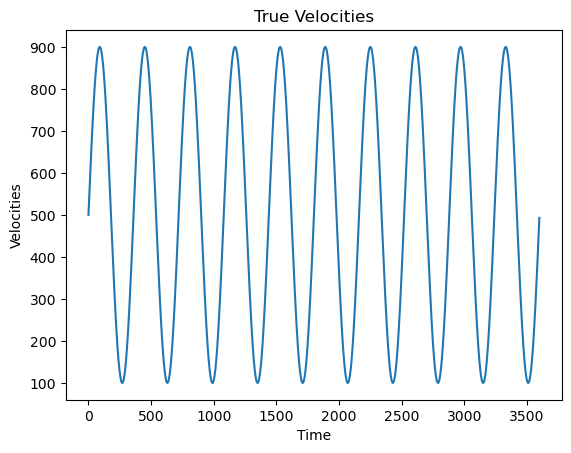

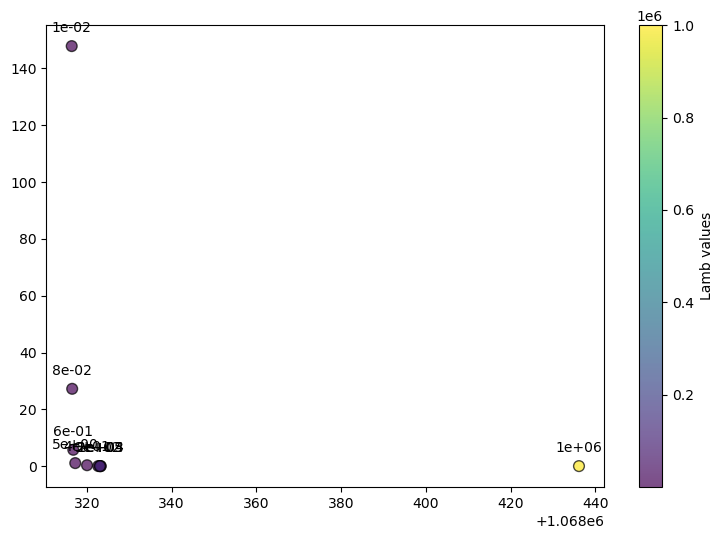

Choose the most appropriate lambda value:  40


Inversion with noise took: 0.01425 seconds
Inversion without noise took: 0.01310 seconds


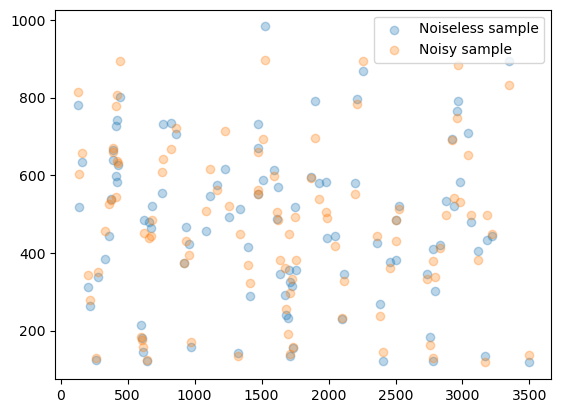

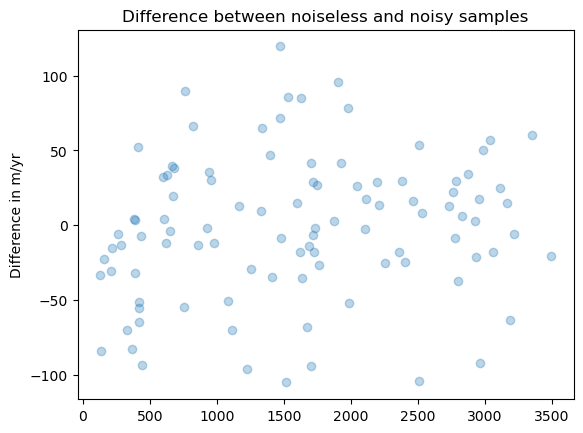

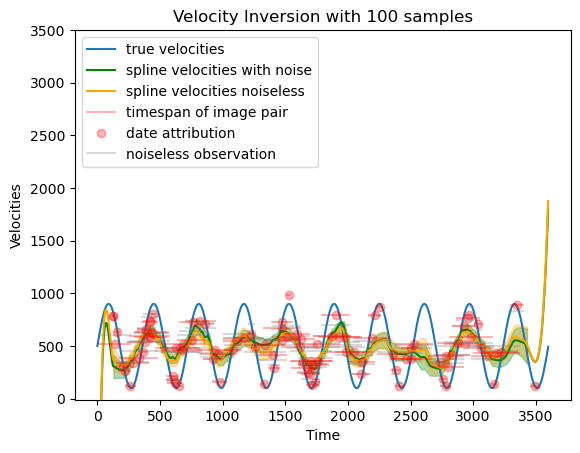

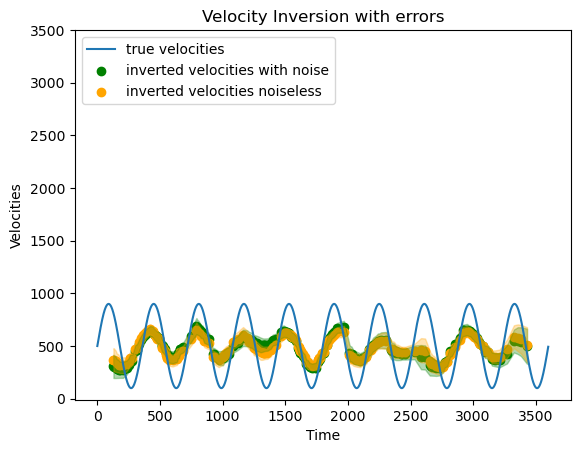

In [45]:
# Choose the amount of samples for the inversion
N = 100

LCurve = True

# Choose a case
case_number = 1

# Choose error [m/day]
sigma = 0.1

v, t = case(case_number) # Generate the glacier function
Runner(N, lamb, case, t, v, sigma, LCurve) # Run the inversion

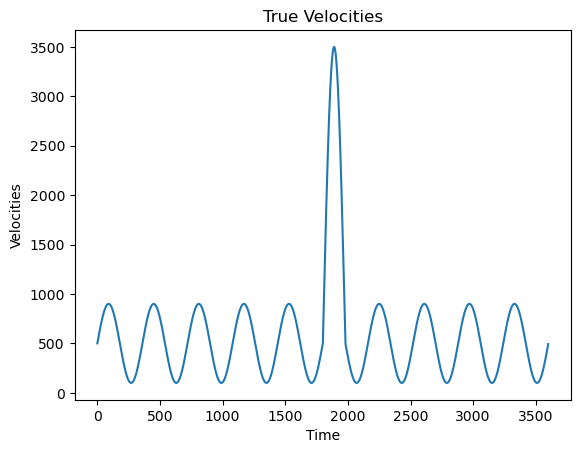

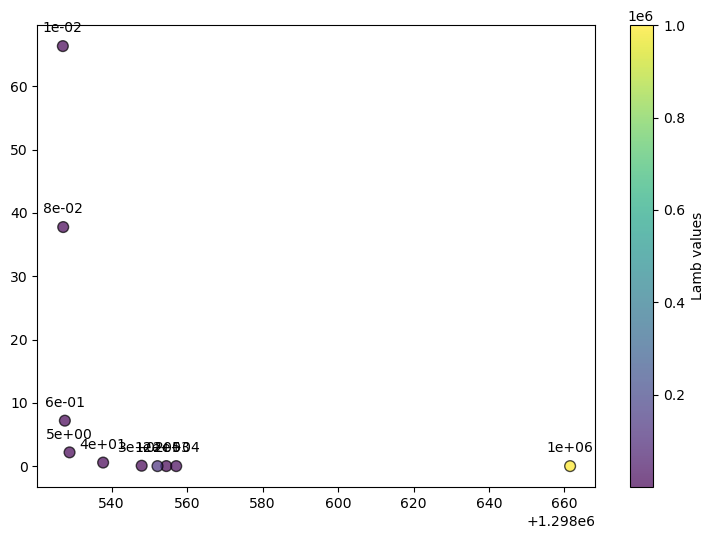

Choose the most appropriate lambda value:  5


Inversion with noise took: 0.01437 seconds
Inversion without noise took: 0.01396 seconds


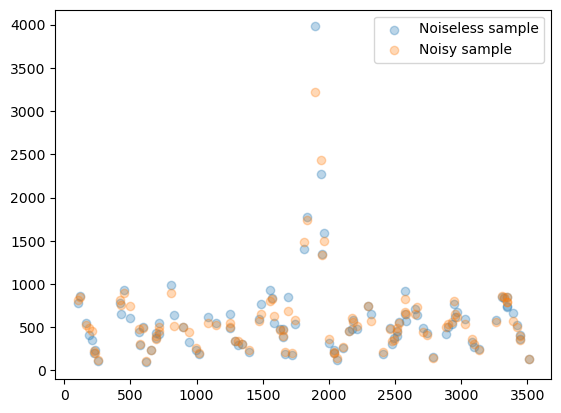

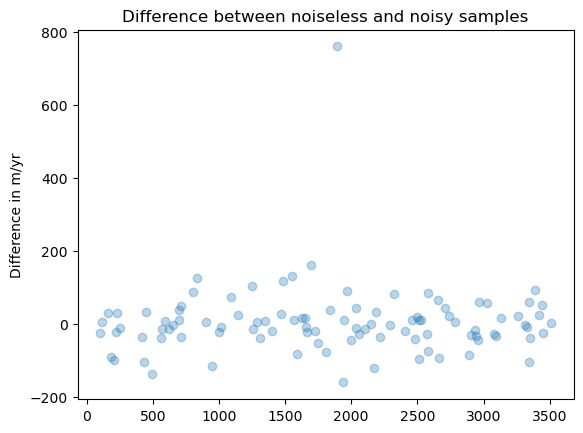

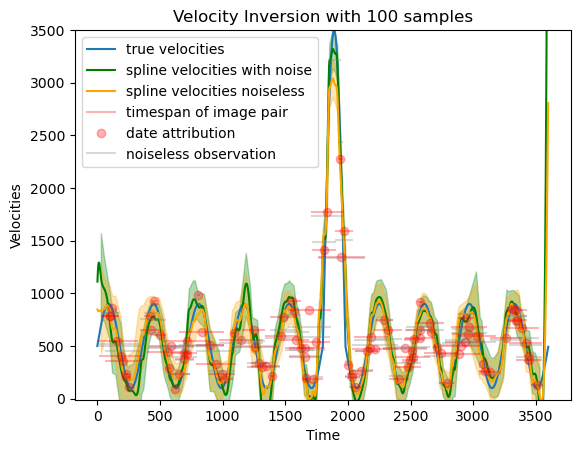

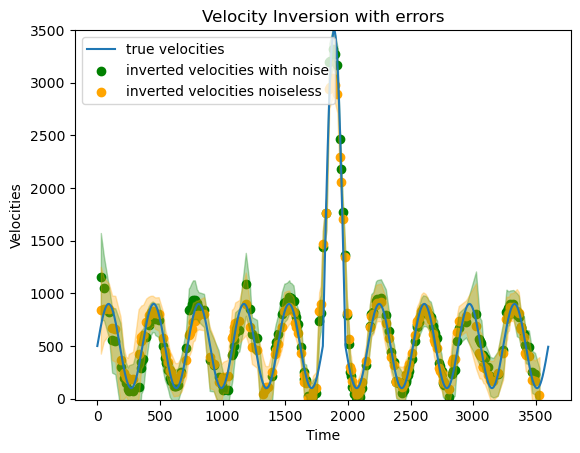

In [46]:
# Choose the amount of samples you have
N = 100

# Choose a case
case_number = 2

# Choose error [m/day]
sigma = 0.1

v, t = case(case_number) # Generate the glacier function
Runner(N, lamb, case, t, v, sigma, LCurve) # Run the inversion

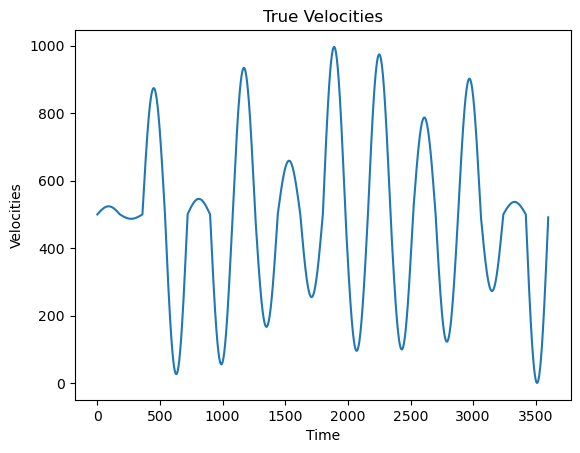

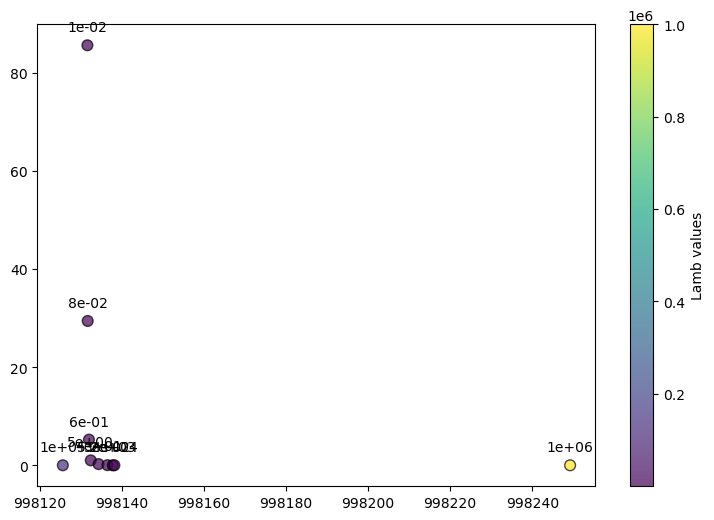

Choose the most appropriate lambda value:  5


Inversion with noise took: 0.01525 seconds
Inversion without noise took: 0.01411 seconds


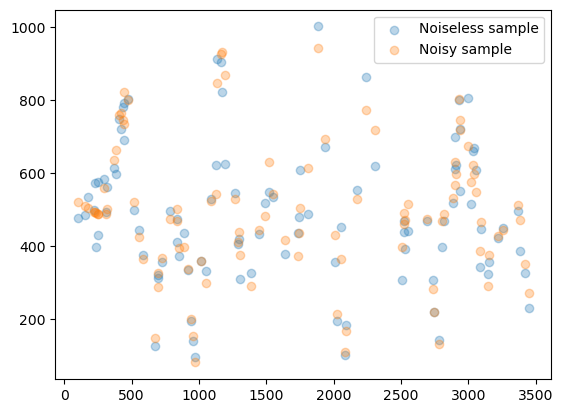

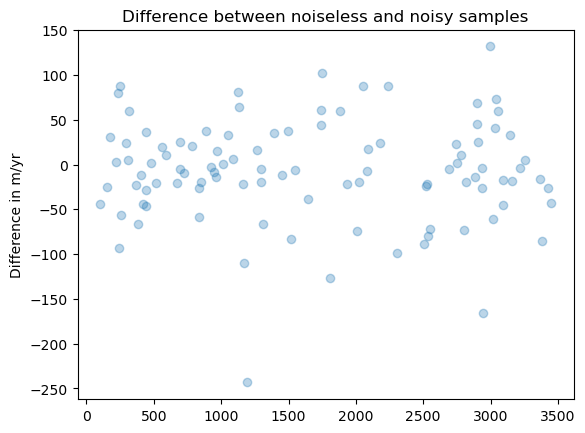

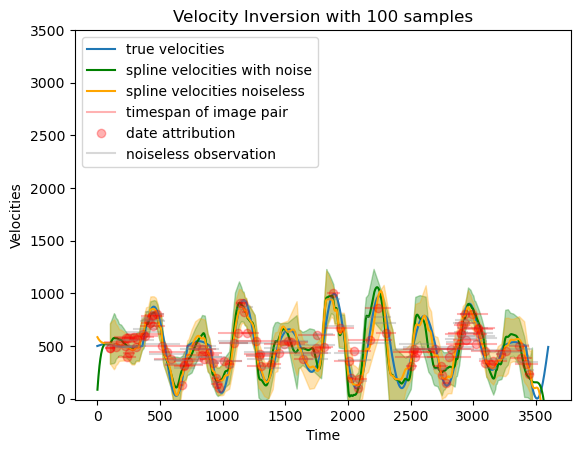

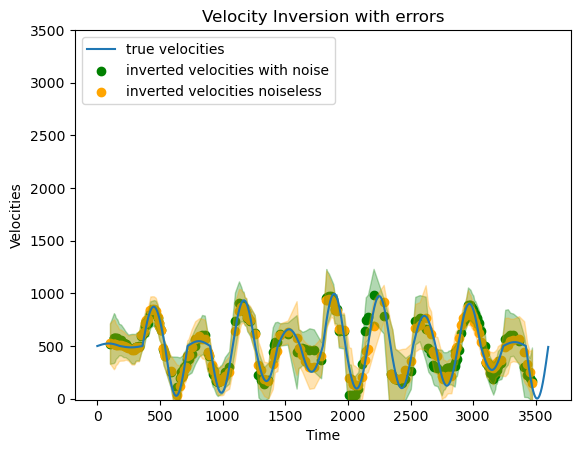

In [47]:
# Choose the amount of samples you have
N = 100

# Choose a case
case_number = 3

# Choose error [m/day]
sigma = 0.1

v, t = case(case_number) # Generate the glacier function
Runner(N, lamb, case, t, v, sigma, LCurve) # Run the inversion